In [1]:
import torch
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 0. Prep

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if image_path.is_dir():
#     print("Directory already exists")
# else:
#     print("Creating directory")
#     image_path.mkdir(parents=True, exist_ok=True)

# # download
# with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
#     request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
#     print("Downloading")
#     f.write(request.content)

# # unzip
# with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
#     print("Unzipping")
#     zip_ref.extractall(image_path)

In [4]:
import os

def walk_through_dirs(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories in {len(filenames)} images in {dirpath}")

In [5]:
walk_through_dirs(image_path)

There are 2 directories in 0 images in data/pizza_steak_sushi
There are 3 directories in 0 images in data/pizza_steak_sushi/test
There are 0 directories in 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories in 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories in 31 images in data/pizza_steak_sushi/test/sushi
There are 3 directories in 0 images in data/pizza_steak_sushi/train
There are 0 directories in 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories in 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories in 72 images in data/pizza_steak_sushi/train/sushi


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
import random
from PIL import Image

# random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Image class: {image_class} | height: {img.height} | width: {img.width}")
img

## 1. Transform image to tensor

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(8, 3))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Shape: {img_as_array.shape}")

In [31]:
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    # resize images to 64 x 64
    transforms.Resize(size=(64, 64)),
    # flip the images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # turn image to tensor from default PIL (H x W x C) to (C x H x W)
    transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=None): # n = number of images to transform at a time
    """
    Selects random images from a path of images and loads/transforms
    them then plots the original vs the transformed version
    """
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nDim: {f.size}")
            
            # transform and plot target image
            transformed_image = transform(f).permute(1,2,0) # since the image is already transformed to (C x H x W), we need to change it to what matplotlib expects which is (H x W x C)
            ax[1].set_title(f"Transformed\nDim: {transformed_image.shape}")
            ax[1].imshow(transformed_image)
            fig.suptitle(f"Class: {image_path.parent.stem}")

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3)
    

## 2. Create Dataset

### Option 1: using `torchvision.datasets.ImageFolder`

In [ ]:
# 3. Create dataset(s)
# option 1: using `torchvision.datasets.ImageFolder`

from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for the data
                                  target_transform=None) # transform for the label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

In [ ]:
class_names = train_data.classes
class_names

In [ ]:
# check the data once again
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

In [ ]:
img_permute = img.permute(1,2,0)

print(f"Original shape: {img.shape}")
print(f"Image permute shape: {img_permute.shape}")

plt.figure(figsize=(8, 3))
plt.imshow(img_permute)
plt.title(class_names[label])

### turn dataset to `torch.utils.data.DataLoader`

In [ ]:
# DataLoader turns datasets into iterables so we can customize `batch_size`

from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True) # for the model not to recognize the order in the training data
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False) 

len(train_dataloader), len(test_dataloader)

In [ ]:
# check data
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}") # depends on batch_size

### Option 2: using Custom dataset

#### Create custom dataset

In [40]:
# option 2: Loading image(or anything) data with a custom `Dataset`

import os
import pathlib
from typing import Tuple, Dict, List

from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder name in a target directory"""
    # 1. Get class names by scanning target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise error if classes names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find classes in {directory}")

    # 3. Create a dictionary of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

    return classes, class_to_idx

find_classes(train_dir)

In [42]:
# Custom `Dataset`  
class ImageFolderCustom(Dataset):
    def __init__(self, target_dir: str, transform=None):
        # super().__init__()
        # create attributes
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        # setup transform
        self.transform = transform
        # create classes and class_to_idx
        self.classes, self.class_to_idx = find_classes(target_dir)

    # create function to load images
    def load_image(self, index: int) -> Image.Image:
        "opens an image path via path and returns it"
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # optional: override __len__() 
    def __len__(self) -> int:
        "returns total number of samples"
        return len(self.paths)
    
    # override __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "returns one sample of data, data and label (X, y)"
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return untransformed data, label

In [43]:
train_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()])


In [ ]:
train_data_custom = ImageFolderCustom(target_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir,
                                      transform=test_transforms)

len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

In [45]:
# function to display random images
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10, # images to display
                          display_shape: bool = True,
                          seed: int = None):
    
    # adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10. Setting to 10...")

    # set the seed
    if seed:
        random.seed(seed)

    # get sample random indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # setup plot
    plt.figure(figsize=(16,8))

    # loop through random indexes and plot them
    for i, target_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[target_sample][0], dataset[target_sample][1]
        # adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1,2,0)
        
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape: {targ_image_adjust.shape}"
        plt.title(title)

In [ ]:
# display random images from ImageFolder
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

In [ ]:
# display random images from ImageFolderCustom
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names)

In [ ]:
# custom loaded images to dataloader
train_dataloader_custom = DataLoader(train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS)

img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

## 3. Other forms of transform

### image augmentation

#### trivial augment
selects randomly from other augmentation types and applies them at some level of intensity

In [49]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5), # 31 is max
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [ ]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

In [ ]:
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

## 4. Summary

### Model0: TinyVGG without data augmentation

#### 4.1 create transforms and loading data for Model 0

In [7]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [11]:
# create transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [12]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

In [13]:
class_names = train_data_simple.classes

In [14]:
# 2. Turn datasets to DataLoader
import os
from torch.utils.data import DataLoader

#
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

#
train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

#### 4.2 Create TinyVGG model class

In [15]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2) # default stride value is the same as kernel size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, 
                         stride=2) # default stride value is the same as kernel size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # turn the output of convolutional blocks into feature vector
            nn.Linear(in_features=hidden_units*13*13, # determine what should be multiplied to hidden units
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)

        # or better
        # return self.classifier(self.conv_block_2(self.conv_block_1(x)))
        
        return x

In [16]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels
                  hidden_units=10, # same as with TinyVGG architecture
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [17]:
# to check if forward method is working correctly and input & output shapes are correct
# try a forward pass on a single image

# 1. get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [18]:
# 2. try a forward pass
model_0(image_batch)

# you'll get an error
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1690 and 10x3)

# to fix, you need to get the product of hidden units(10) * height(13) * width(13) from conv_block_2
# so it would satisfy the matrix multiplication (32x1690 and 10x3) ~ (1690 and 10 should match)
# see self.classifier layer


tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7226e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.3062e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

#### 4.3 use `torchinfo` to get an idea of the shapes going through our model

In [19]:
# instead of using print statements to see the shapes we'll use torchinfo
from torchinfo import summary

summary(model=model_0, 
        input_size=[1, 3, 64, 64], # its like putting in 1 batch of image in a forward pass
)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

#### 4.4 Train Step function

In [20]:
from torchmetrics import Accuracy

accuracy = Accuracy(task="multiclass", num_classes=len(class_names))


In [21]:
# train_step() -- takes in a model and dataloader and trains the model on the dataloader
# test_step() -- takes in a model and dataloader and evaluates the model on the dataloader

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device):
    
    # put the model in train mode
    model.train()

    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    testing_acc = 0

    # loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X) # outputs model logits

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1) # get labels
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    # Adjust metrcis to get the average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

#### 4.5 Test step function

In [22]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device):
    
    # put model in eval mode
    model.eval()

    # setup test loss and test accuracy
    test_loss, test_acc = 0, 0

    # turn on inference mode
    with torch.inference_mode():
        # loop through DataLoader batches
        for batch, (X, y ) in enumerate(dataloader):
            # send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. forward pass
            test_pred_logits = model(X)

            # 2. calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

        # Adjust metrics to get average loss and accuracy per batch
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

        return test_loss, test_acc

#### 4.6 combine train & test step on single function

In [23]:
from tqdm.auto import tqdm

# 1. create train function that takes in various model params
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          device: str,
          epochs: int = 5):
    
    # 2. create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # 3. loop through training and test steps
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # 4. print
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss {test_loss:.4f} | Test acc {test_acc:.4f}")

        # 5. update results dictionaries
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. 
    return results

/home/cr1xx/.local/share/virtualenvs/pytorch_try-Q_-lm9Fh/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 4.7 train and evaluate model 0

In [24]:
torch.manual_seed(42)

NUM_EPOCHS = 5

# recreate an instance of TinyVGG(model 0)
model_0 = TinyVGG(input_shape=3, # color channels
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

# loss & optim
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.001)

# start timer
from timeit import default_timer as timer

start_time = timer()

# train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device=device,
                        epochs=NUM_EPOCHS)

# end timer
end_time = timer()
print(f"Train time: {end_time - start_time:.3f} s")

 20%|██        | 1/5 [00:00<00:02,  1.80it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss 1.0983 | Test acc 0.3011


 40%|████      | 2/5 [00:01<00:01,  1.83it/s]

Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss 1.0697 | Test acc 0.5417


 60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss 1.0807 | Test acc 0.4924


 80%|████████  | 4/5 [00:02<00:00,  1.81it/s]

Epoch: 3 | Train loss: 1.0844 | Train acc: 0.4023 | Test loss 1.0607 | Test acc 0.5833


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4141 | Test loss 1.0656 | Test acc 0.5644
Train time: 2.780 s


#### 4.8 Plot the loss curves of Model 0

In [25]:
import matplotlib.pyplot as plt

def plot_loss_curves(results: dict[str, list[float]]):
    # get the loss values of the results dictionary
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # get accuracy values
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # epochs (steps)
    epochs = range(len(results["train_loss"]))

    # 
    plt.figure(figsize=(15, 7))

    # loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="train_acc")
    plt.plot(epochs, test_accuracy, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

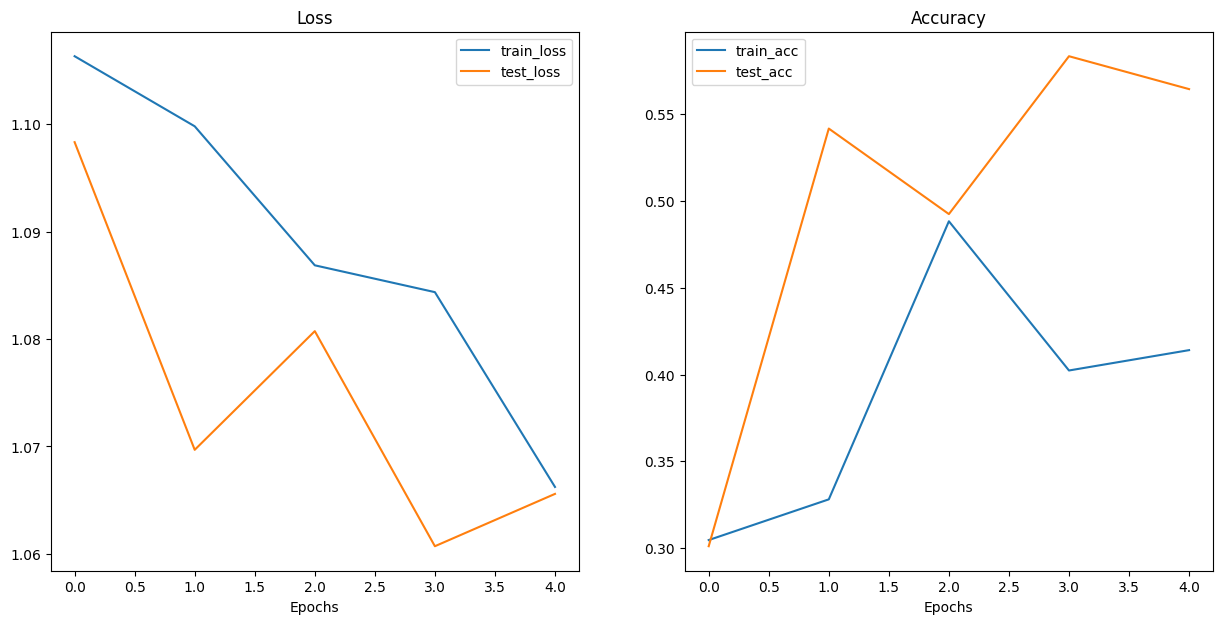

In [26]:
plot_loss_curves(model_0_results)

#### 4.9 Model 1: TinyVGG with Data Augmentation

In [28]:
# create training transform with data augmentation
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [29]:
# create train and test `Dataset`
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [31]:
# create `DataLoader`
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(dataset=test_data_simple,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

In [32]:
# use the same model class as model_0 but this time using augmented training data
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [33]:
NUM_EPOCHS = 5

# loss & optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# start timer
from timeit import default_timer as Timer
start_time = timer()

# train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_augmented,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device=device,
                        epochs=NUM_EPOCHS)

# end timer
end_time = timer()
print(f"Total time: { end_time - start_time:.3f} s")

 20%|██        | 1/5 [00:00<00:02,  1.66it/s]

Epoch: 0 | Train loss: 1.1068 | Train acc: 0.3047 | Test loss 1.0996 | Test acc 0.2500


 40%|████      | 2/5 [00:01<00:01,  1.64it/s]

Epoch: 1 | Train loss: 1.0987 | Train acc: 0.3086 | Test loss 1.0714 | Test acc 0.5417


 60%|██████    | 3/5 [00:01<00:01,  1.65it/s]

Epoch: 2 | Train loss: 1.0893 | Train acc: 0.4180 | Test loss 1.0776 | Test acc 0.6042


 80%|████████  | 4/5 [00:02<00:00,  1.66it/s]

Epoch: 3 | Train loss: 1.0981 | Train acc: 0.3086 | Test loss 1.0647 | Test acc 0.6042


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

Epoch: 4 | Train loss: 1.0916 | Train acc: 0.3477 | Test loss 1.0844 | Test acc 0.4223
Total time: 3.011 s


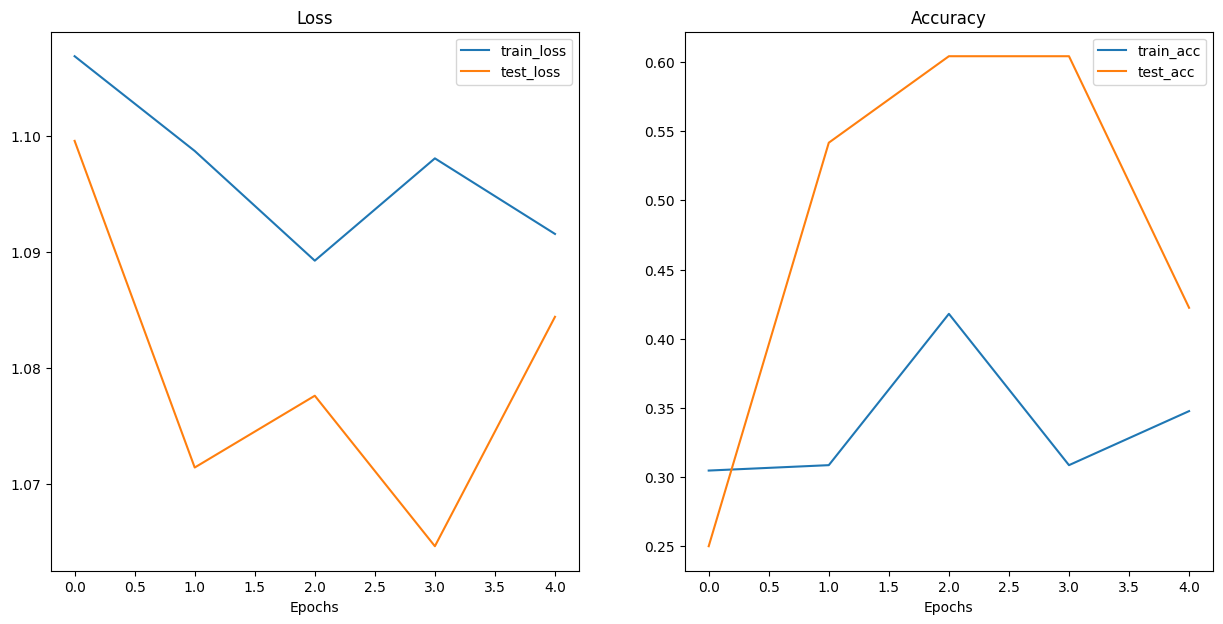

In [34]:
plot_loss_curves(model_1_results)

#### 4.10 Compare model results
few ways to do this:
 - hard coding
 - pytorch + tensorboard (https://pytorch.org/docs/stable/tensorboard.html)
 - weights & biases (https://wandb.ai/site/experiment-tracking/)
 - MLFlow (https://mlflow.org/)

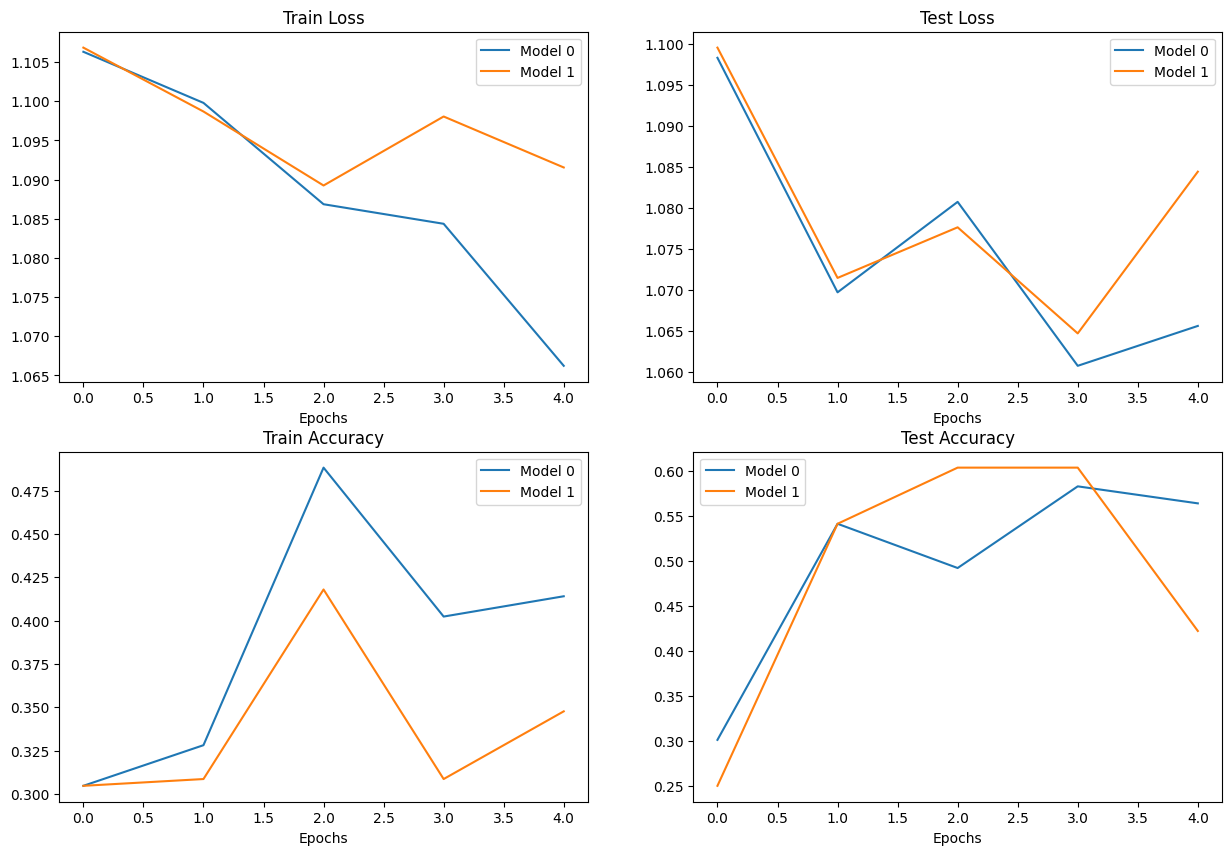

In [41]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

plt.figure(figsize=(15,10))
epochs = range(len(model_0_df))

# train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

#### 4.11 making prediction on a custom image
making predictions on samples(images) that does not exist on training or testing dataset

In [43]:
# download custom image
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

# download if not existing
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/04-pizza-dad.jpeg")
        print("Downloading custom image")
        f.write(request.content)
else:
    print("Image already exists. Skipping download")

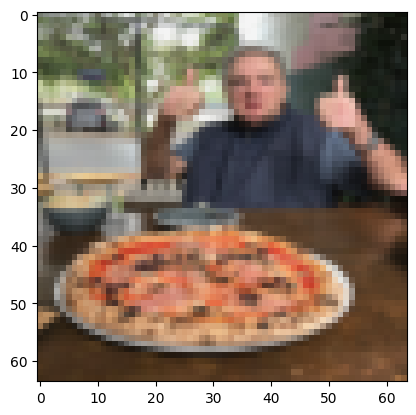

In [59]:
# make sure the custom image is in the same format as the data our model was trained on
# - tensor form with dtype of torch.float32
# - has shape of (64, 64, 3)
# - on the right device

import torchvision

# read in custom image
custom_image_uint8 = torchvision.io.read_image(path=custom_image_path) # read_image default dtype is uint8
# print(custom_image_uint8.shape)
# print(custom_image_uint8.dtype)

# convert to float32 and move to device
custom_image = custom_image_uint8.type(torch.float32).to(device)
# print(custom_image.dtype)

# make sure the tensor values are between 0 and 1 because that is what our model was trained on 
custom_image = custom_image / 255. # 255. because thats the standard image format 0-255

# create transforms pipeline
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

# transform custom image using the pipeline
custom_image_transformed = custom_image_transform(custom_image)

# check the transformation
plt.imshow(custom_image_transformed.permute(1,2,0))

In [61]:
# add batch size to image because our model has batch size dimension
custom_image_transformed.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [68]:
# try prediction
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred

tensor([[-0.1352,  0.0129, -0.0427]])

In [70]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3071, 0.3561, 0.3368]])

In [72]:
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)
class_names, class_names[custom_image_pred_labels]

(['pizza', 'steak', 'sushi'], 'steak')

#### 4.12 Putting the custom image prediction together

In [77]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: list[str],
                        transform: None,
                        device=device):
    
    # load image
    target_image = torchvision.io.read_image(image_path).type(torch.float32)

    # divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # transform if necessary
    if transform:
        target_image = transform(target_image)

    # make sure model is on the target device
    model.to(device)

    # evaluate
    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(0) # add dimension that represents batch dimension
        target_image_pred = model(target_image.to(device))
    
    # convert the raw logits to prediction probabilities
    target_image_pred_prob = torch.softmax(target_image_pred, dim=1)
    # convert prediction probabilities to prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_prob, dim=1)

    # plot the image
    plt.imshow(target_image.squeeze().permute(1,2,0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_prob.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_prob.max().cpu():.3f}"
    plt.title(title)

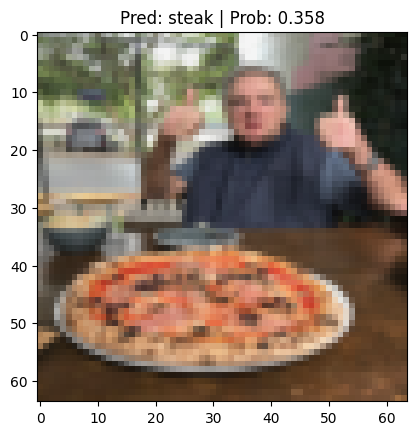

In [80]:
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)